Notebook for checking the contagion simualtions for the different models and datasets!

In [12]:
%load_ext autoreload

In [13]:
%autoreload 2

## **Graph-level analysis**

Compare the graph-level diffusion metrics with the graph characteristics and the Roc-Auc scores

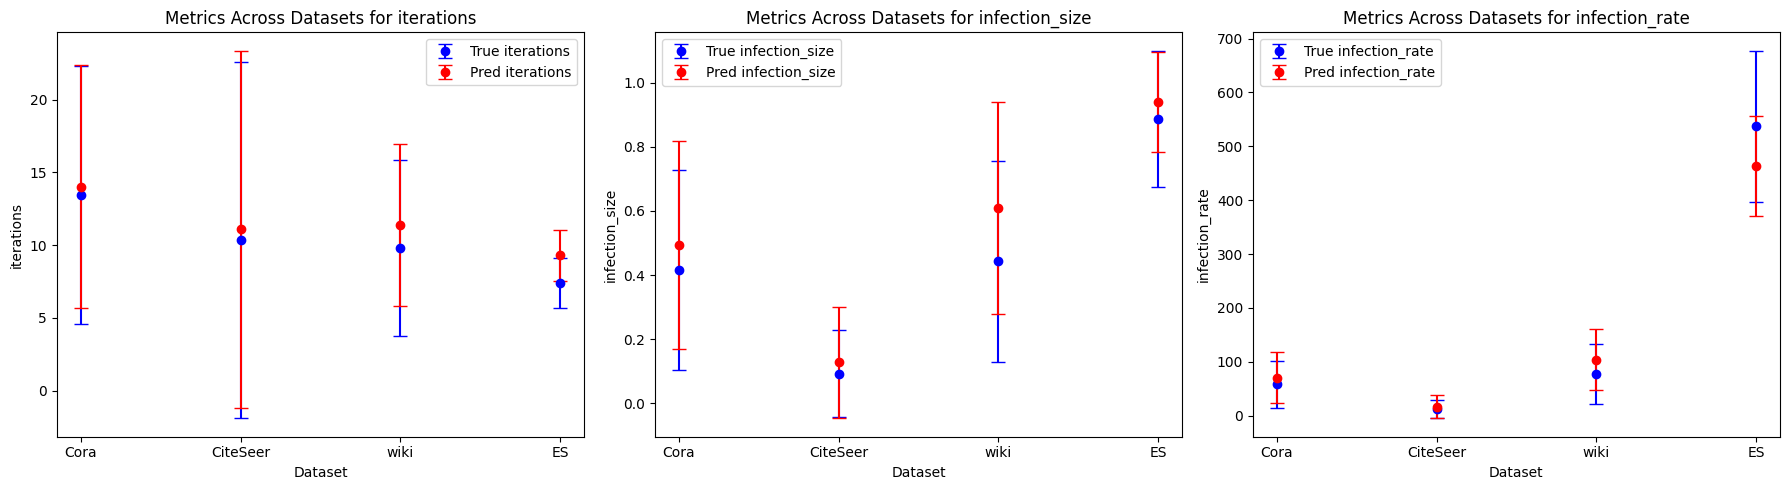

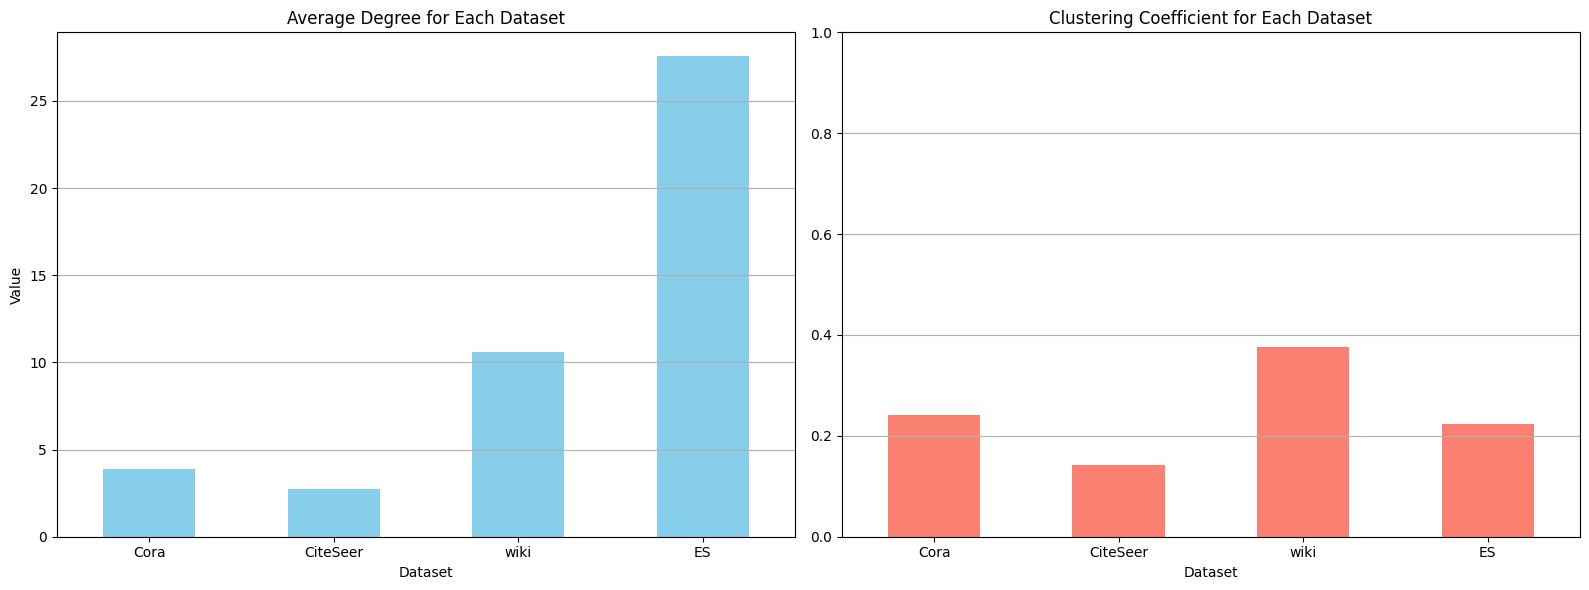

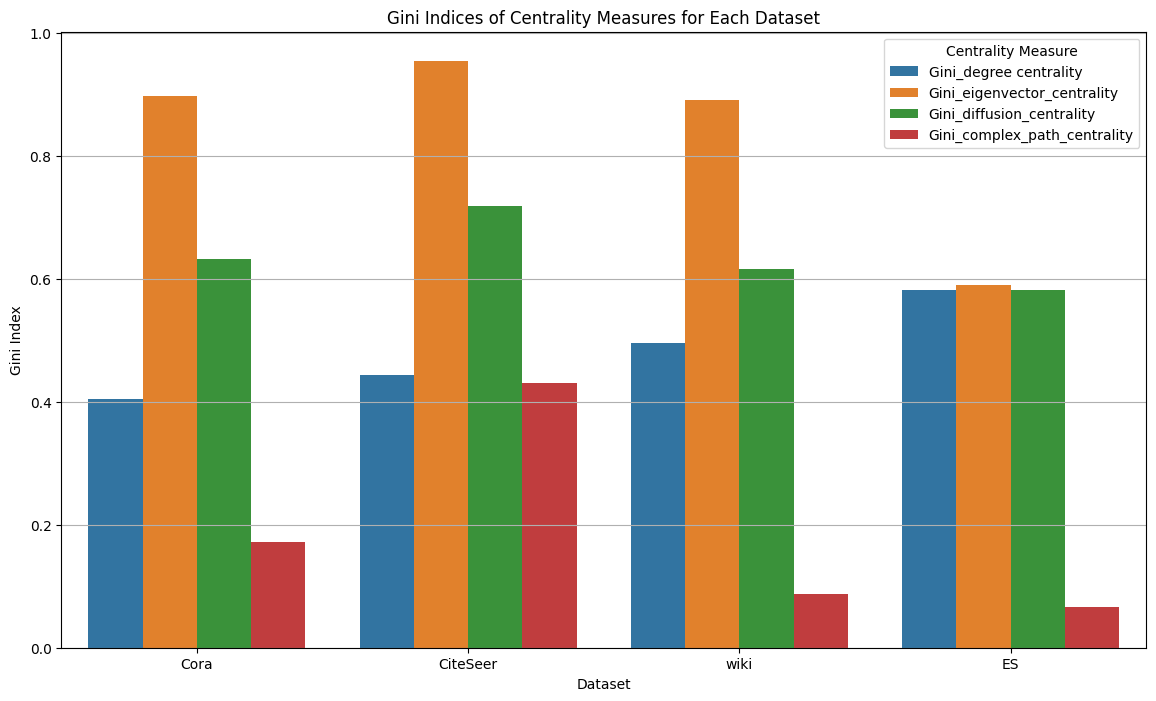

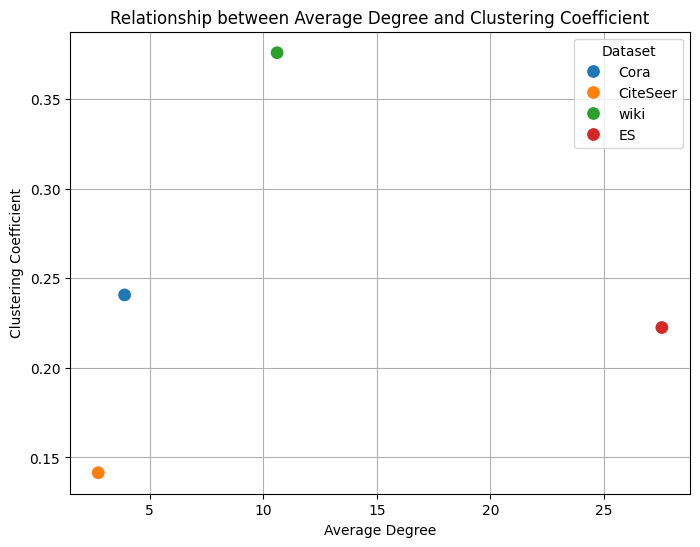

In [9]:
from utils.difffusion_evaluation import diffusion_graph_metrics
from utils.evaluation import graph_level_plot, roc_auc

model = "gcn"
contagion = "s"
prob = 0.5
dataset_list = ["Cora", "CiteSeer", "wiki", "ES"]

metrics = diffusion_graph_metrics(model, contagion, dataset_list, prob)
properties = graph_level_plot(dataset_list, plot=True)
ra_df = roc_auc(model, dataset_list)

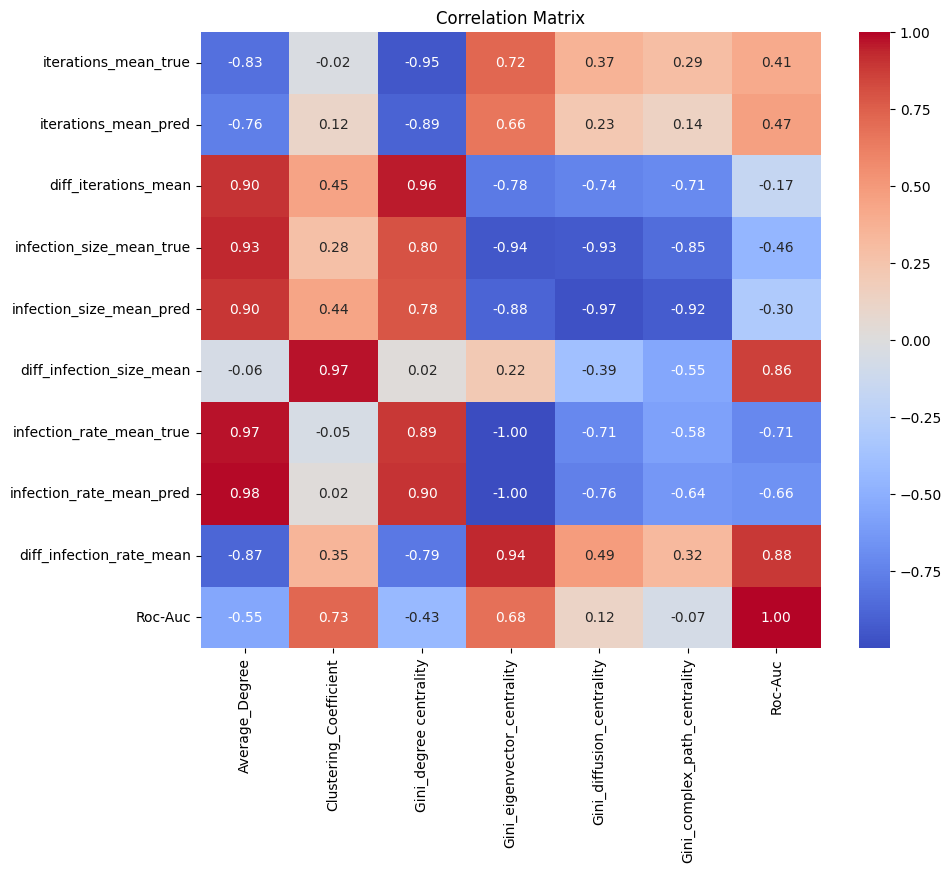

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# join the graph properties and diffusion metrics into the same dataframe
all_df = pd.merge(metrics, properties, on="Dataset")
all_df = pd.merge(all_df, ra_df, on="Dataset")
correlation_matrix = all_df.iloc[:,1:].corr()
correlation_slice = correlation_matrix.loc[list(metrics.columns[1:]) + ["Roc-Auc"], list(properties.columns[1:]) + ["Roc-Auc"]]

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_slice, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig(f"images/corr_matrix_{model}_{contagion}.png", bbox_inches="tight")
plt.show()

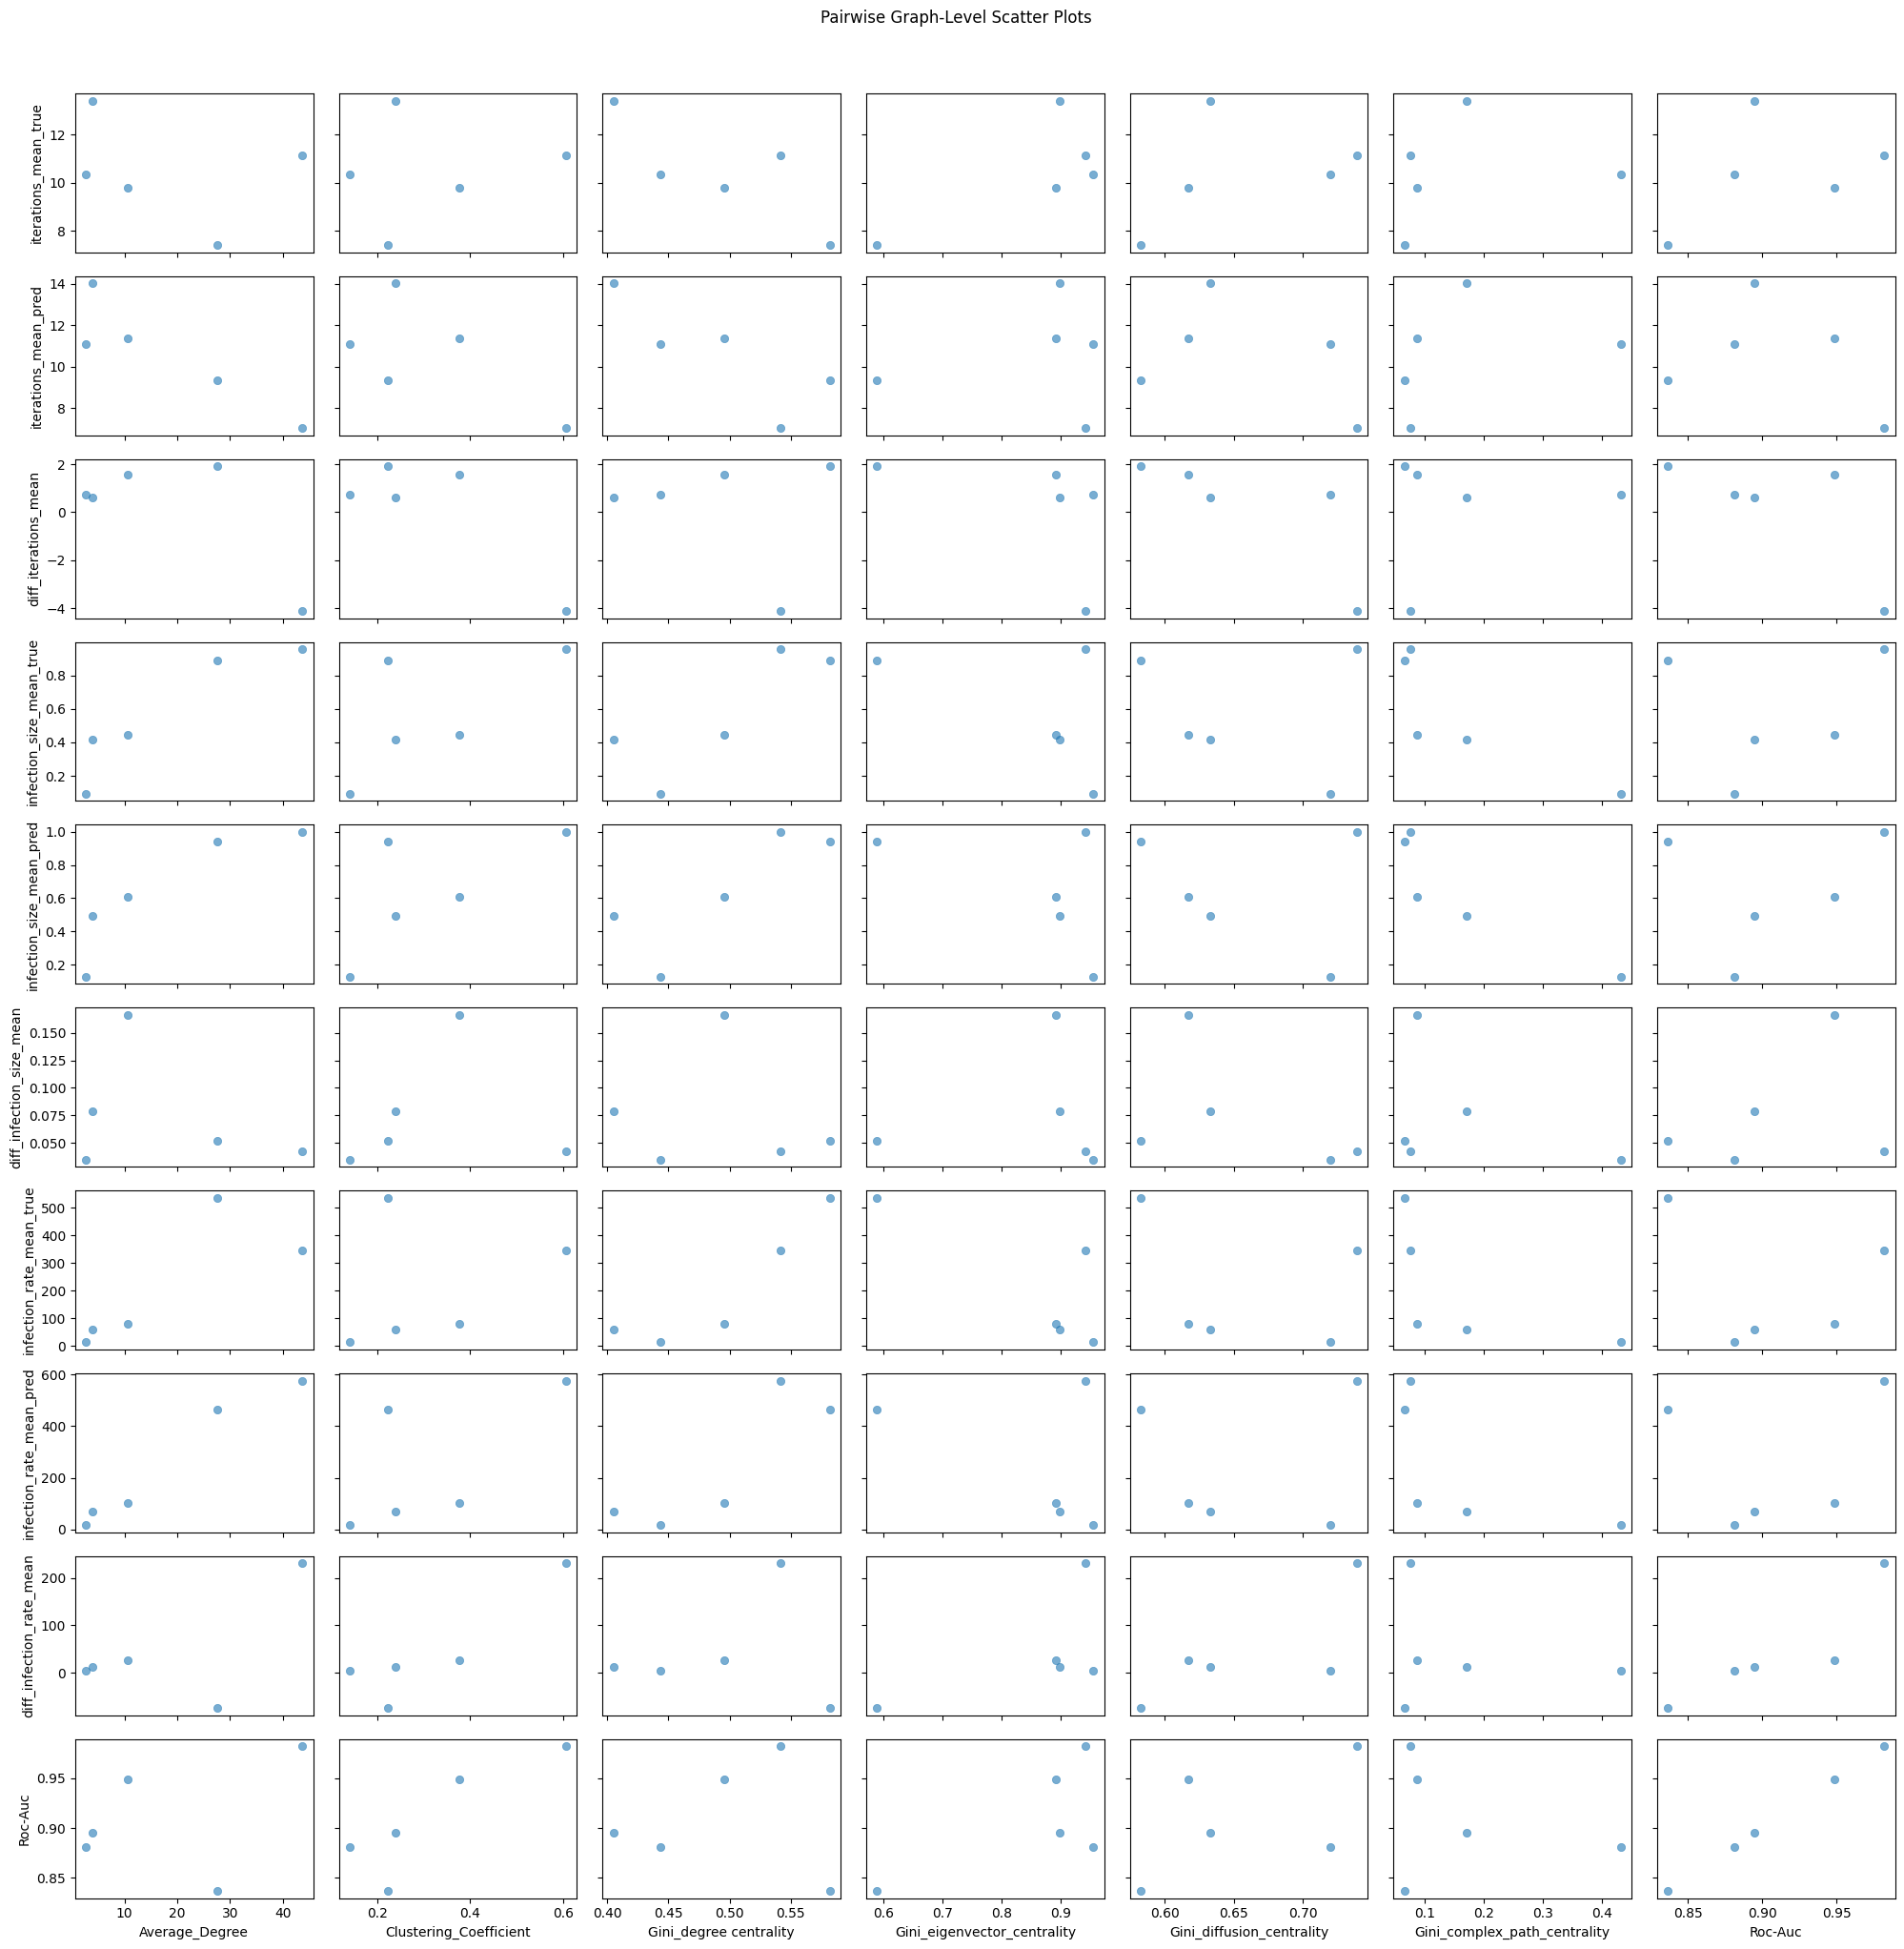

In [21]:
# Define y-axis and x-axis features
y_features = list(metrics.columns[1:]) + ["Roc-Auc"]

x_features = list(properties.columns[1:]) + ["Roc-Auc"]

# Set up the figure for the customized pairwise plots

fig, axes = plt.subplots(len(y_features), len(x_features), figsize=(20, 20), sharex='col', sharey='row')
fig.suptitle(f"Pairwise Graph-Level Scatter Plots", y=1.02)

# Plot each y_feature against each x_feature
for i, y_feature in enumerate(y_features):
    for j, x_feature in enumerate(x_features):
        sns.scatterplot(data=all_df, x=x_feature, y=y_feature, ax=axes[i, j], alpha=0.6, edgecolor=None)
        axes[i, j].set_xlabel(x_feature if i == len(y_features) - 1 else "")  # Set x label only for bottom row
        axes[i, j].set_ylabel(y_feature if j == 0 else "")  # Set y label only for first column

plt.tight_layout()
plt.savefig("images/pairwise_GL_gcn_s.png", bbox_inches="tight")
plt.show()


## **Node-level Analysis**

Compare the node diffusion metrics with their centralities and vcmpr@k scores.

In [36]:
import pandas as pd
from utils.difffusion_evaluation import diffusion_node_metrics
from utils.evaluation import node_level_load
from utils.evaluation import run_vcmpr

model = "gat"
contagion = "s"
prob = 0.5
dataset_list = ["Cora", "CiteSeer", "facebook", "wiki", "ES"]

node_metrics = diffusion_node_metrics(model, contagion, dataset_list, prob)
centralities = node_level_load(datasets)
vcmpr, k = run_vcmpr(model, dataset_list, 5)

In [37]:
merged_dict = {}
all_dict = {}
# Iterate over the keys and merge the corresponding dataframes
for key in node_metrics.keys():
    merged_dict[key] = pd.merge(node_metrics[key], centralities[key], on="node_index")
    merged_dict[key] = pd.merge(merged_dict[key], vcmpr[key], on="node_index")

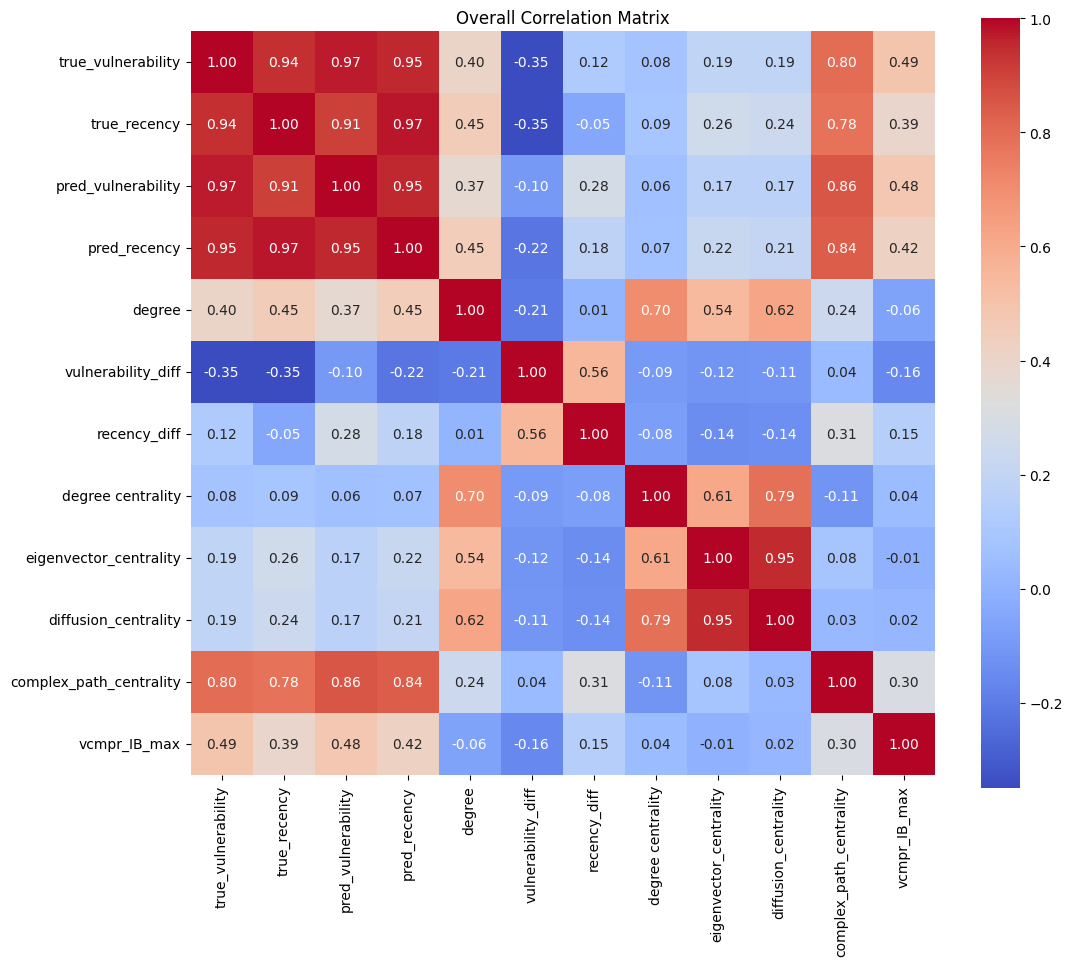

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_overall_correlations(dataframes_dict):
    # Concatenate all dataframes into a single dataframe
    combined_df = pd.concat(dataframes_dict.values(), ignore_index=True)
    combined_df = combined_df.drop(columns=['node_index', 'file'])
    
    # Compute the correlation matrix for the combined dataframe
    overall_correlation_matrix = combined_df.corr()
    
    return overall_correlation_matrix

overall_correlations = compute_overall_correlations(merged_dict)

def plot_overall_correlations(overall_correlation_matrix, save=True):
    plt.figure(figsize=(12, 10))
    sns.heatmap(overall_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Overall Correlation Matrix')
    if save:
        plt.savefig(f"images/node_corr_matrix_{model}_{contagion}.png", bbox_inches="tight")
    plt.show()

plot_overall_correlations(overall_correlations)


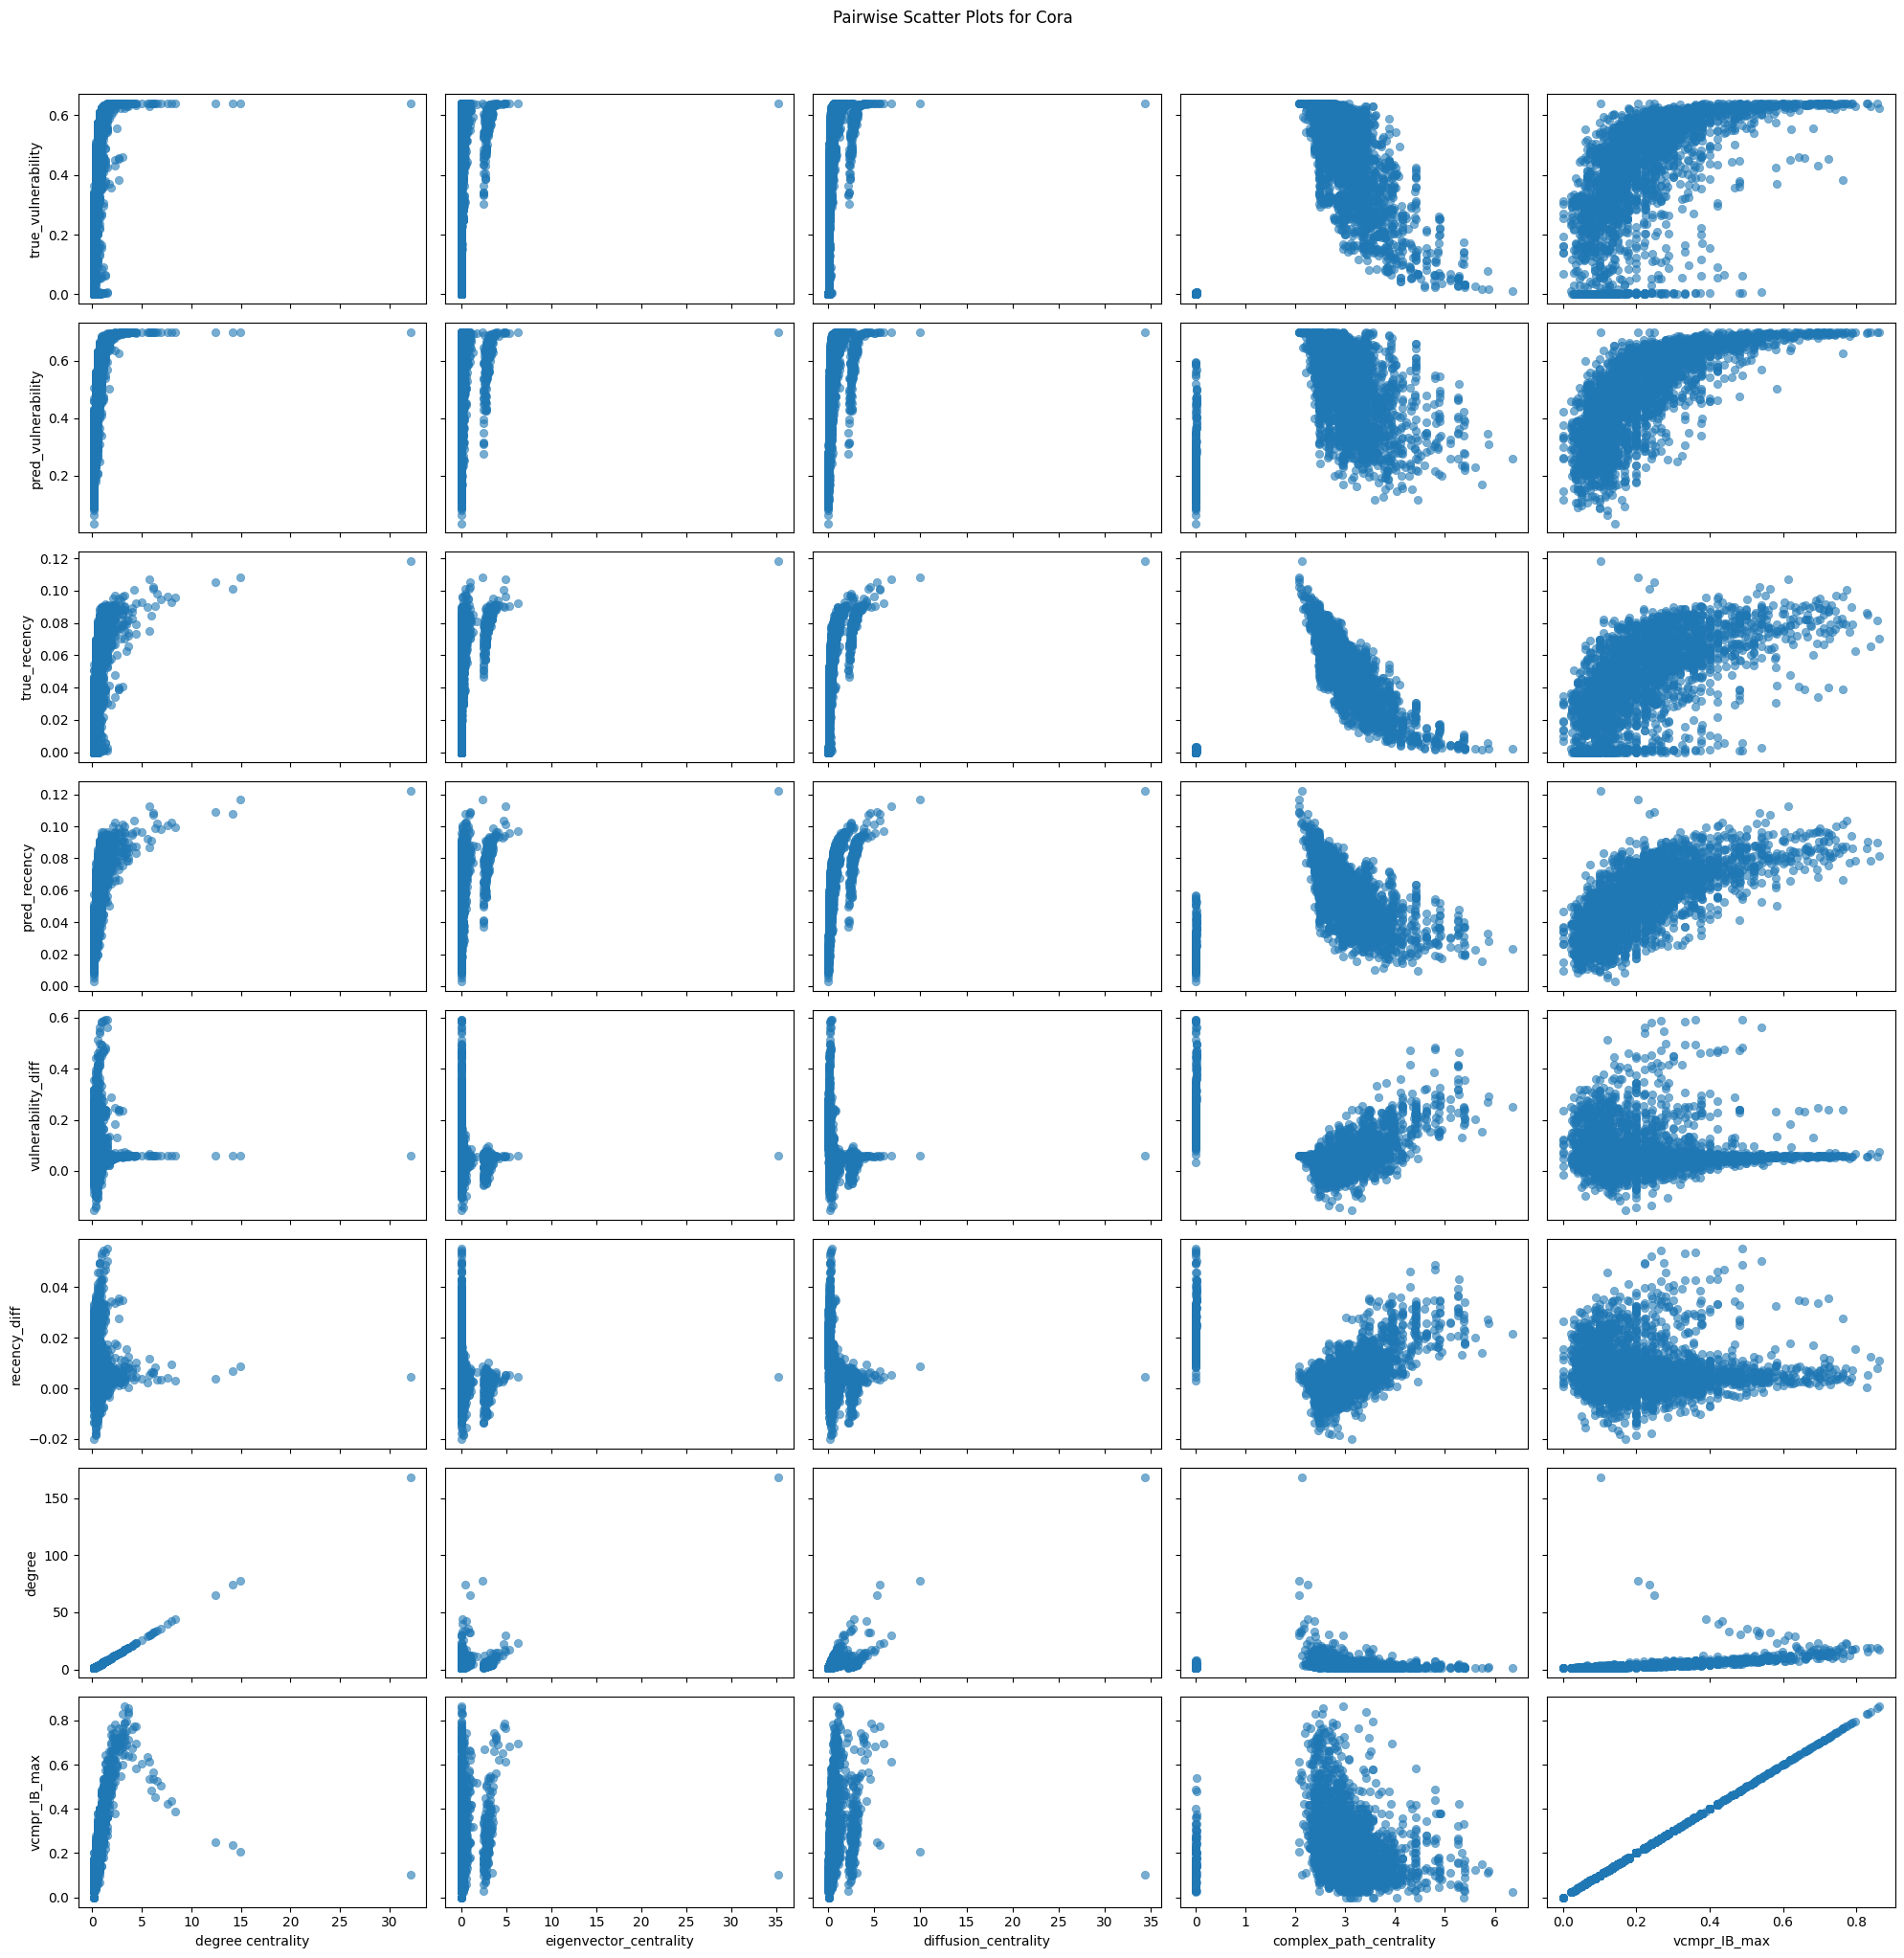

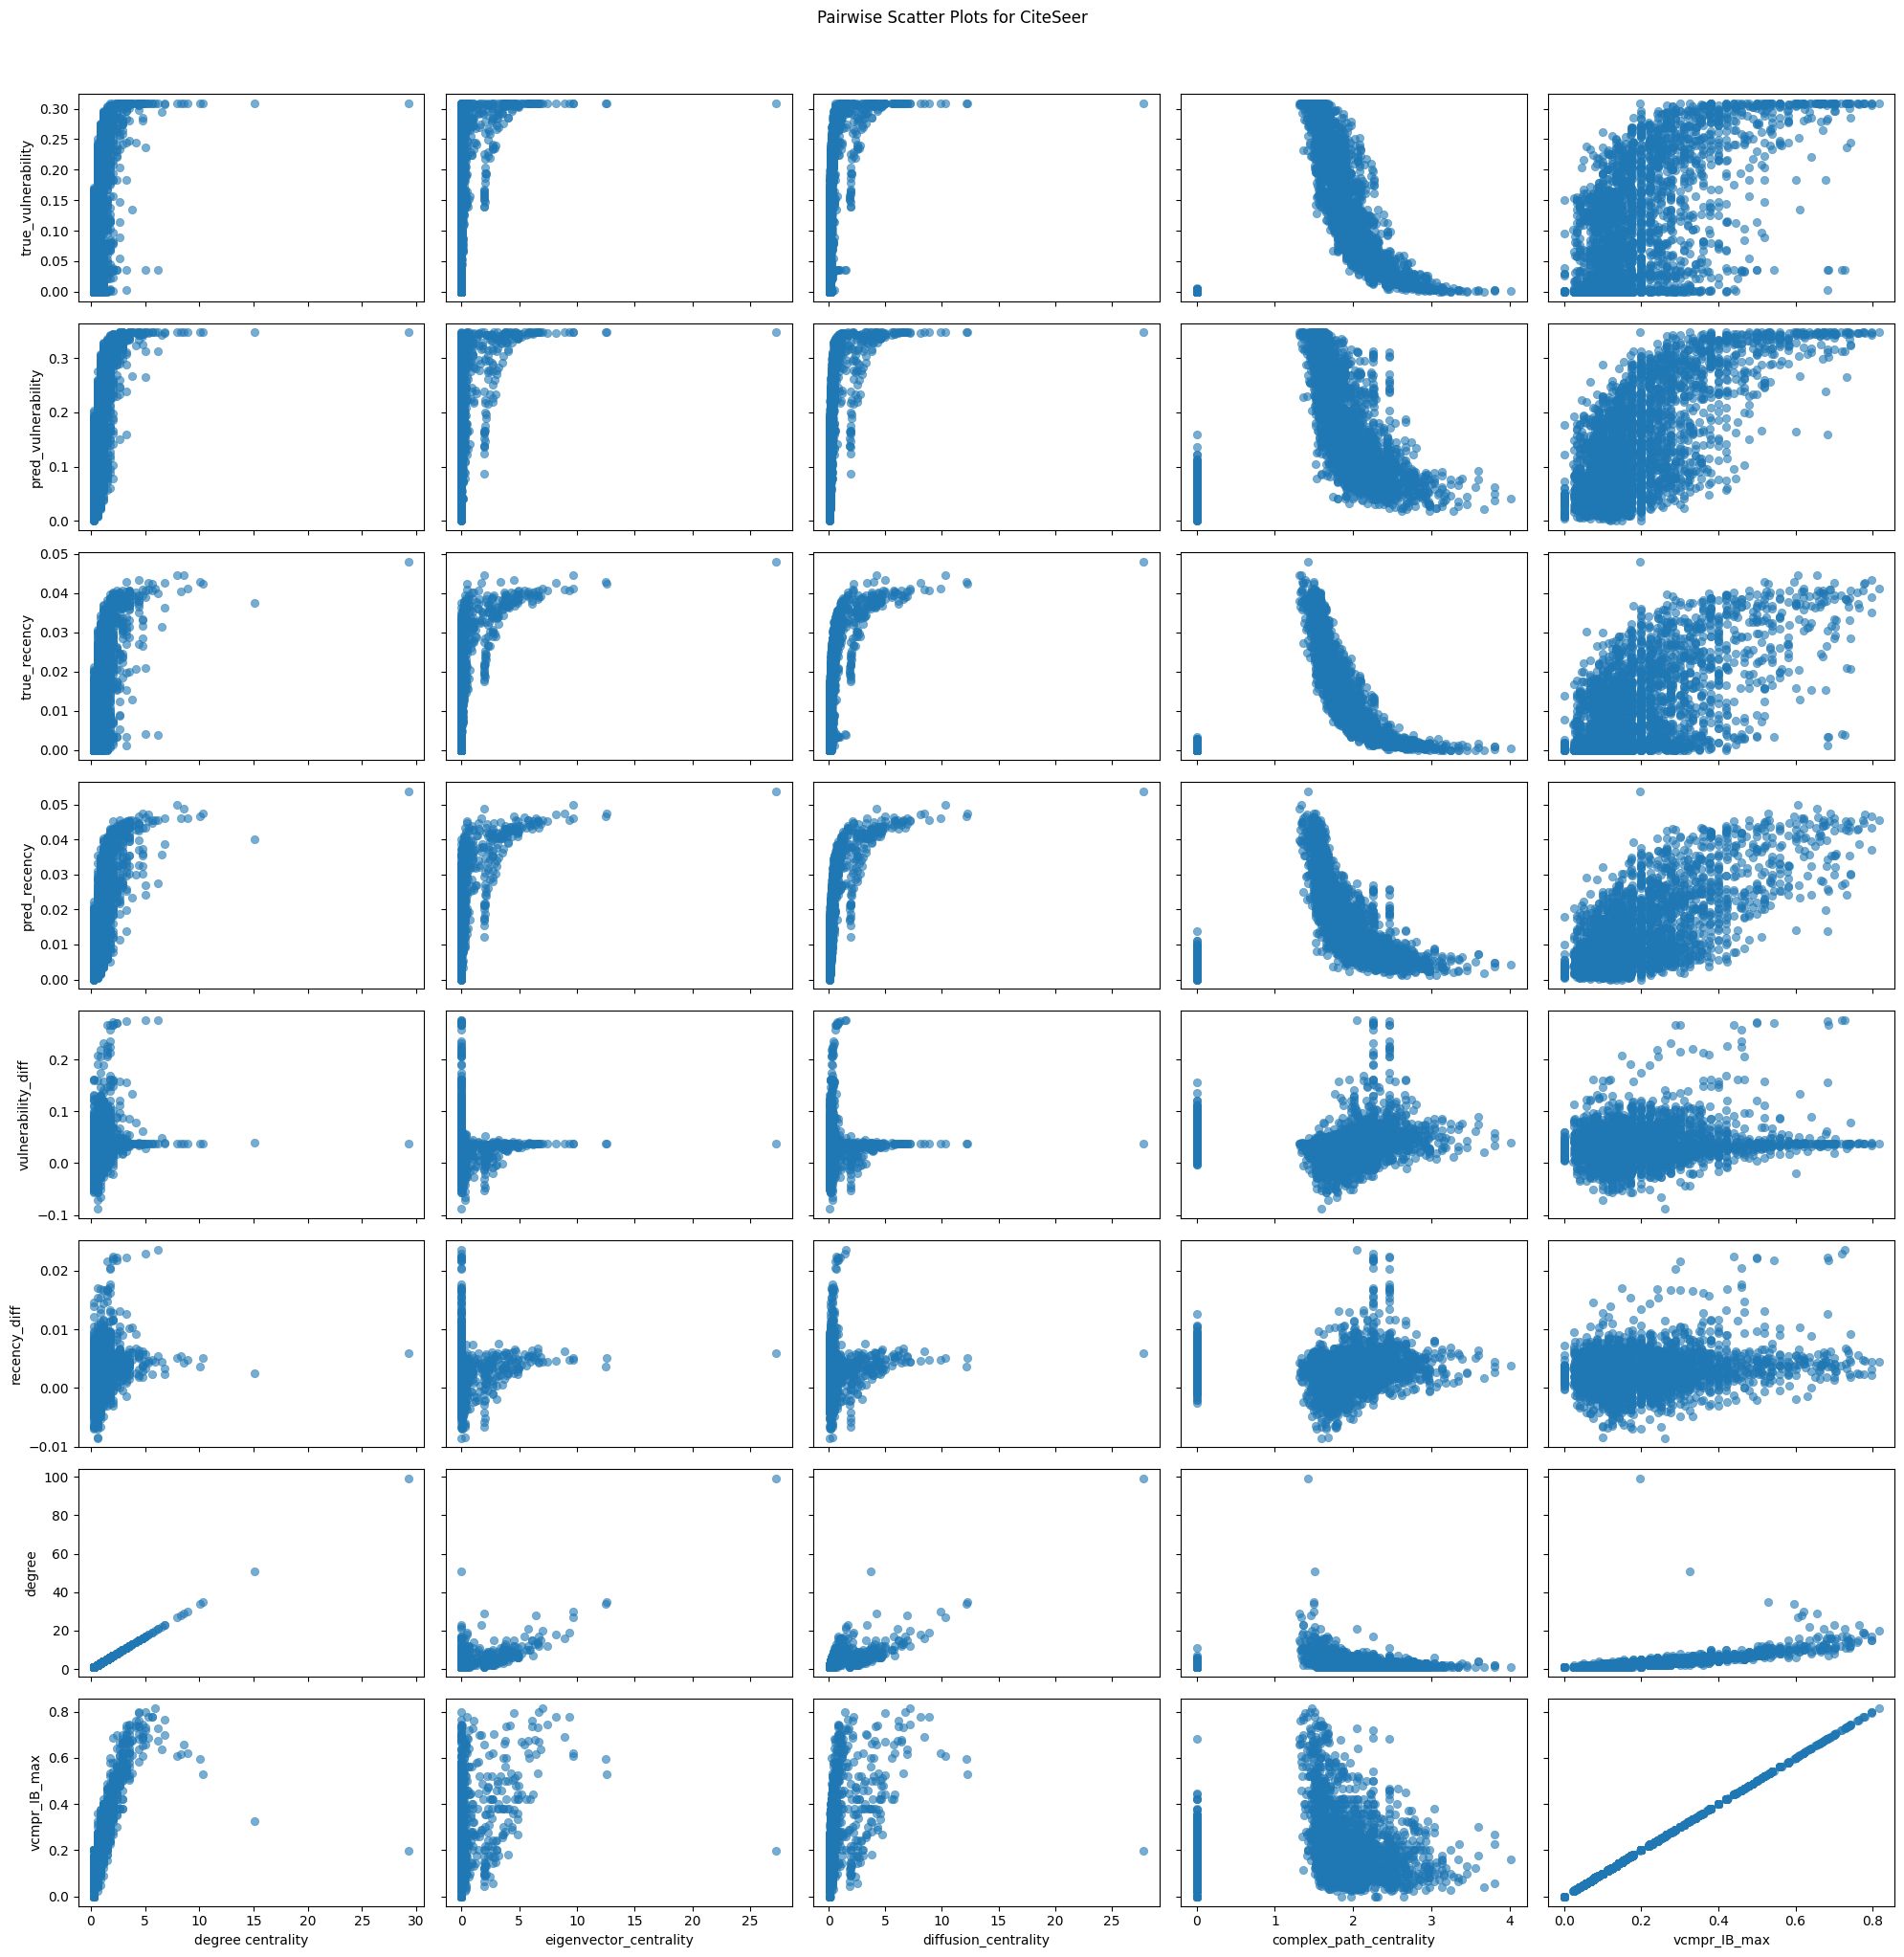

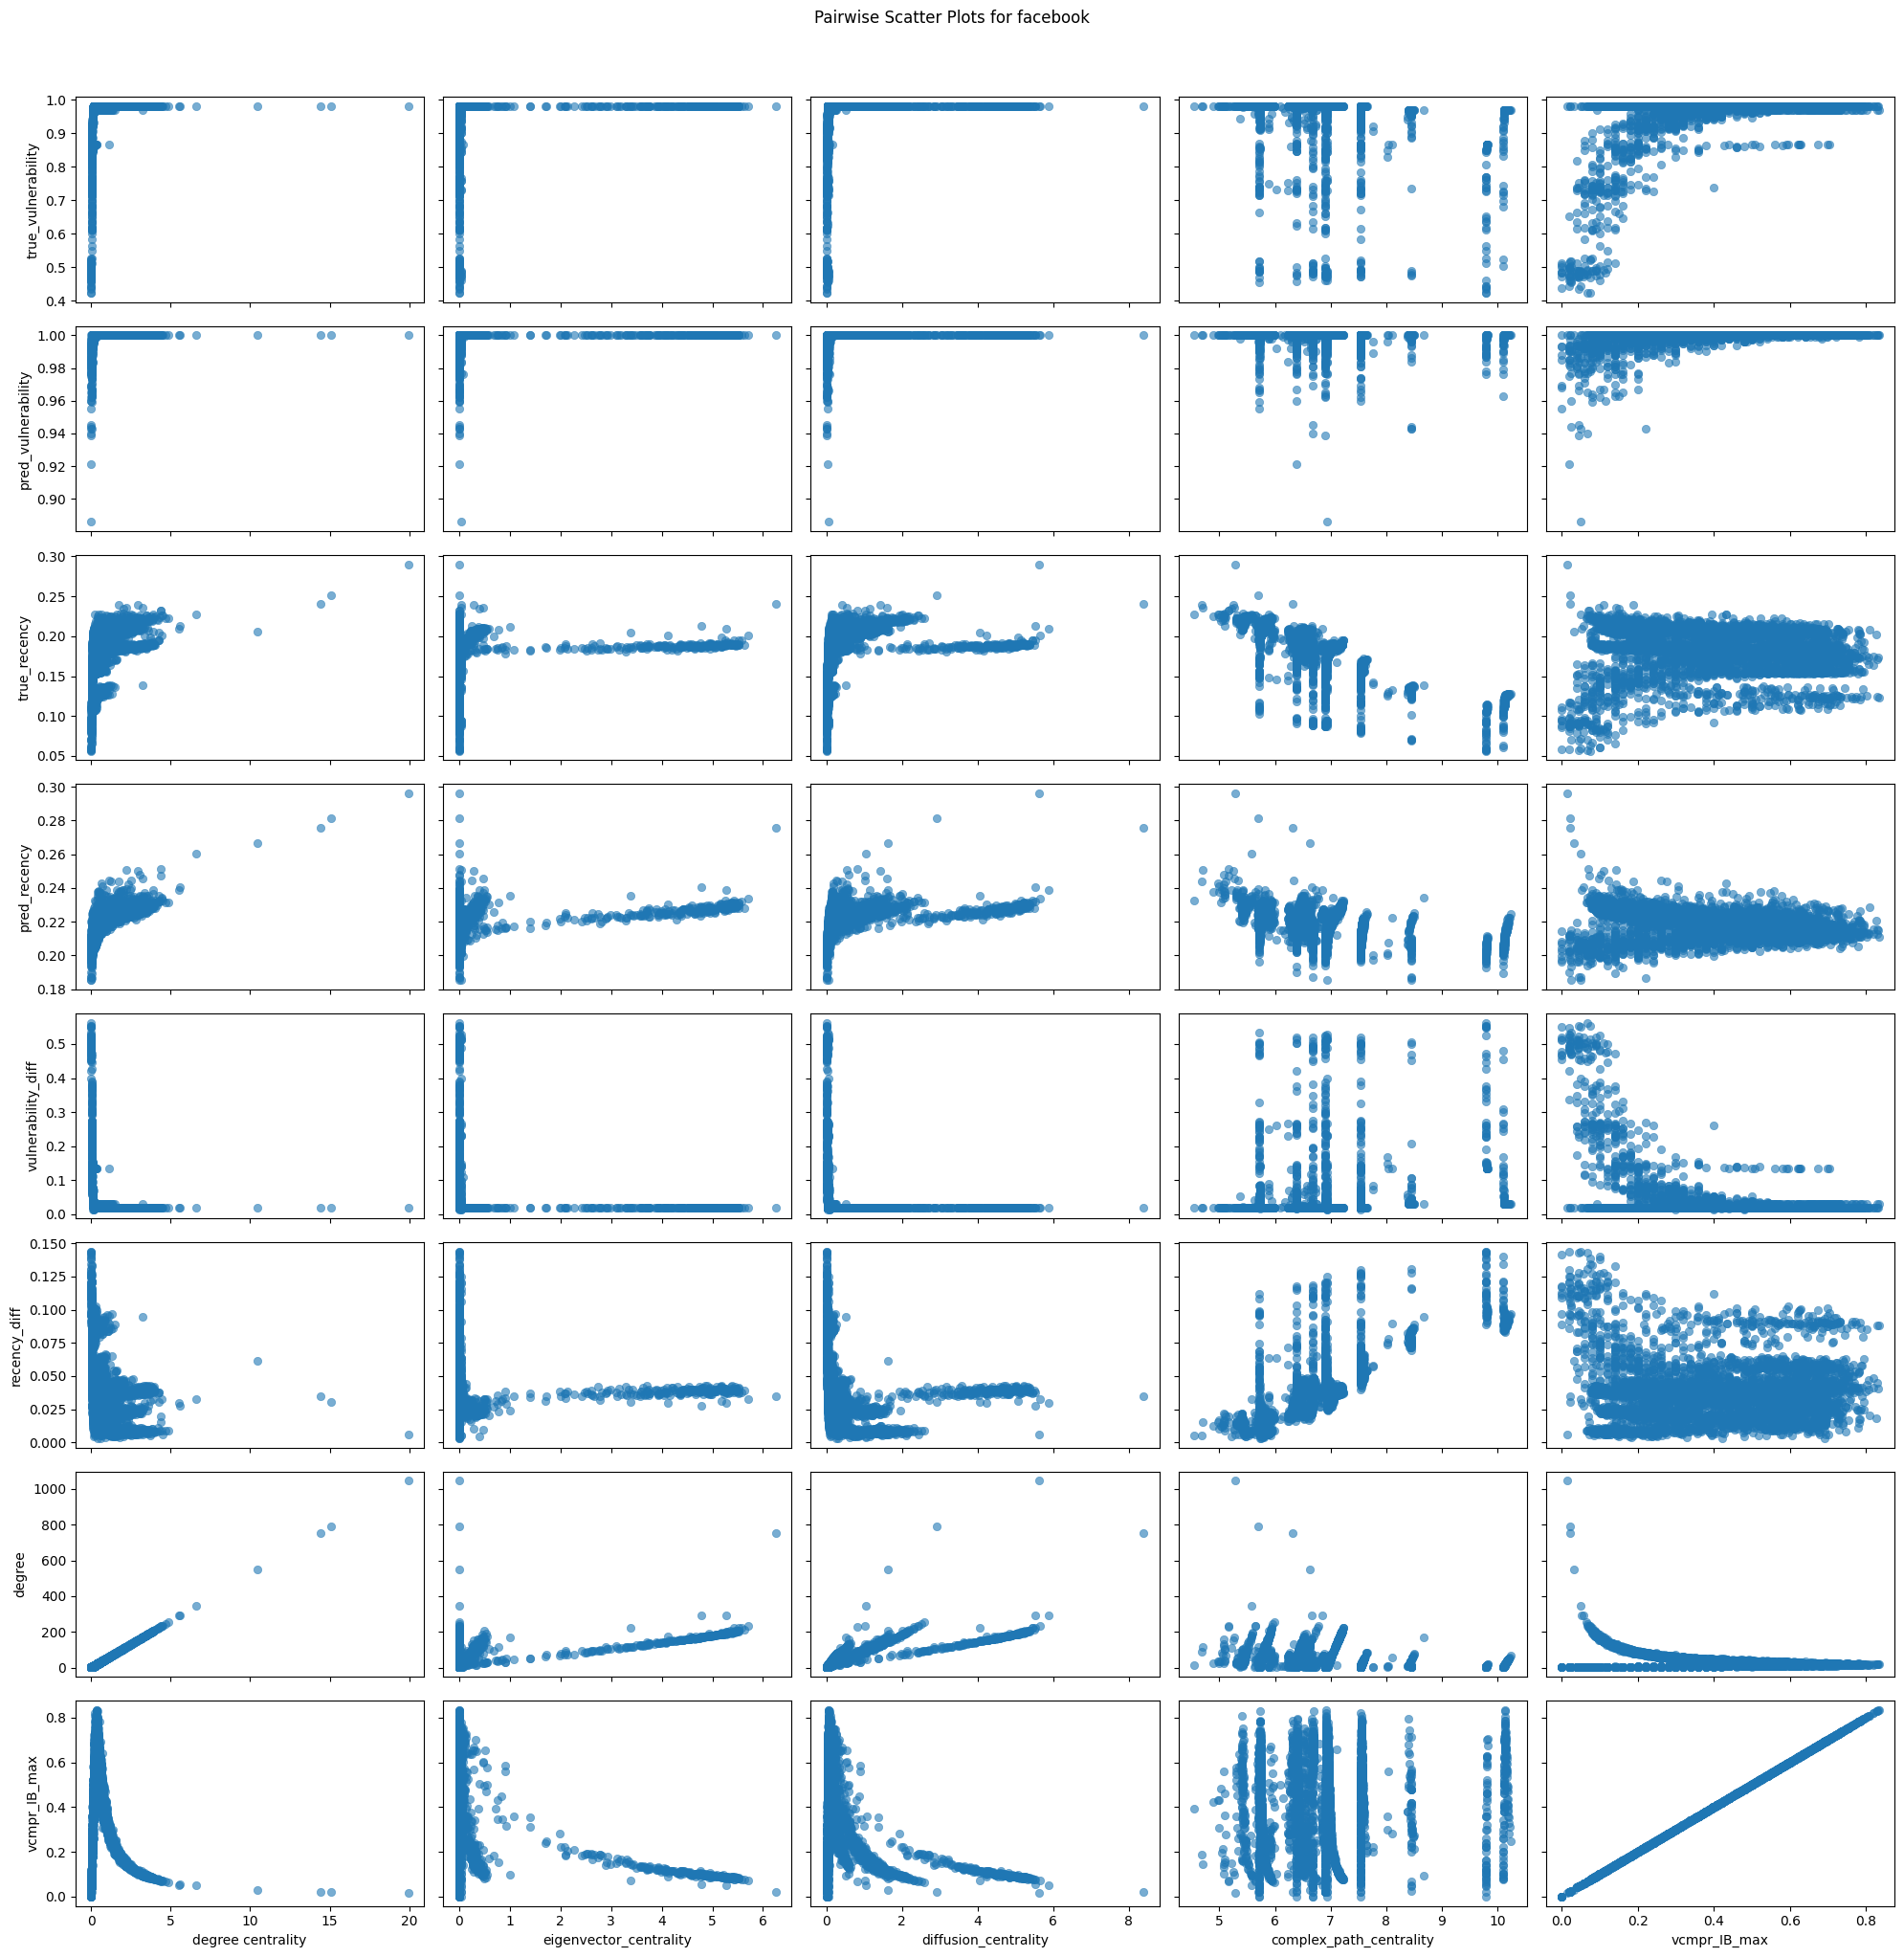

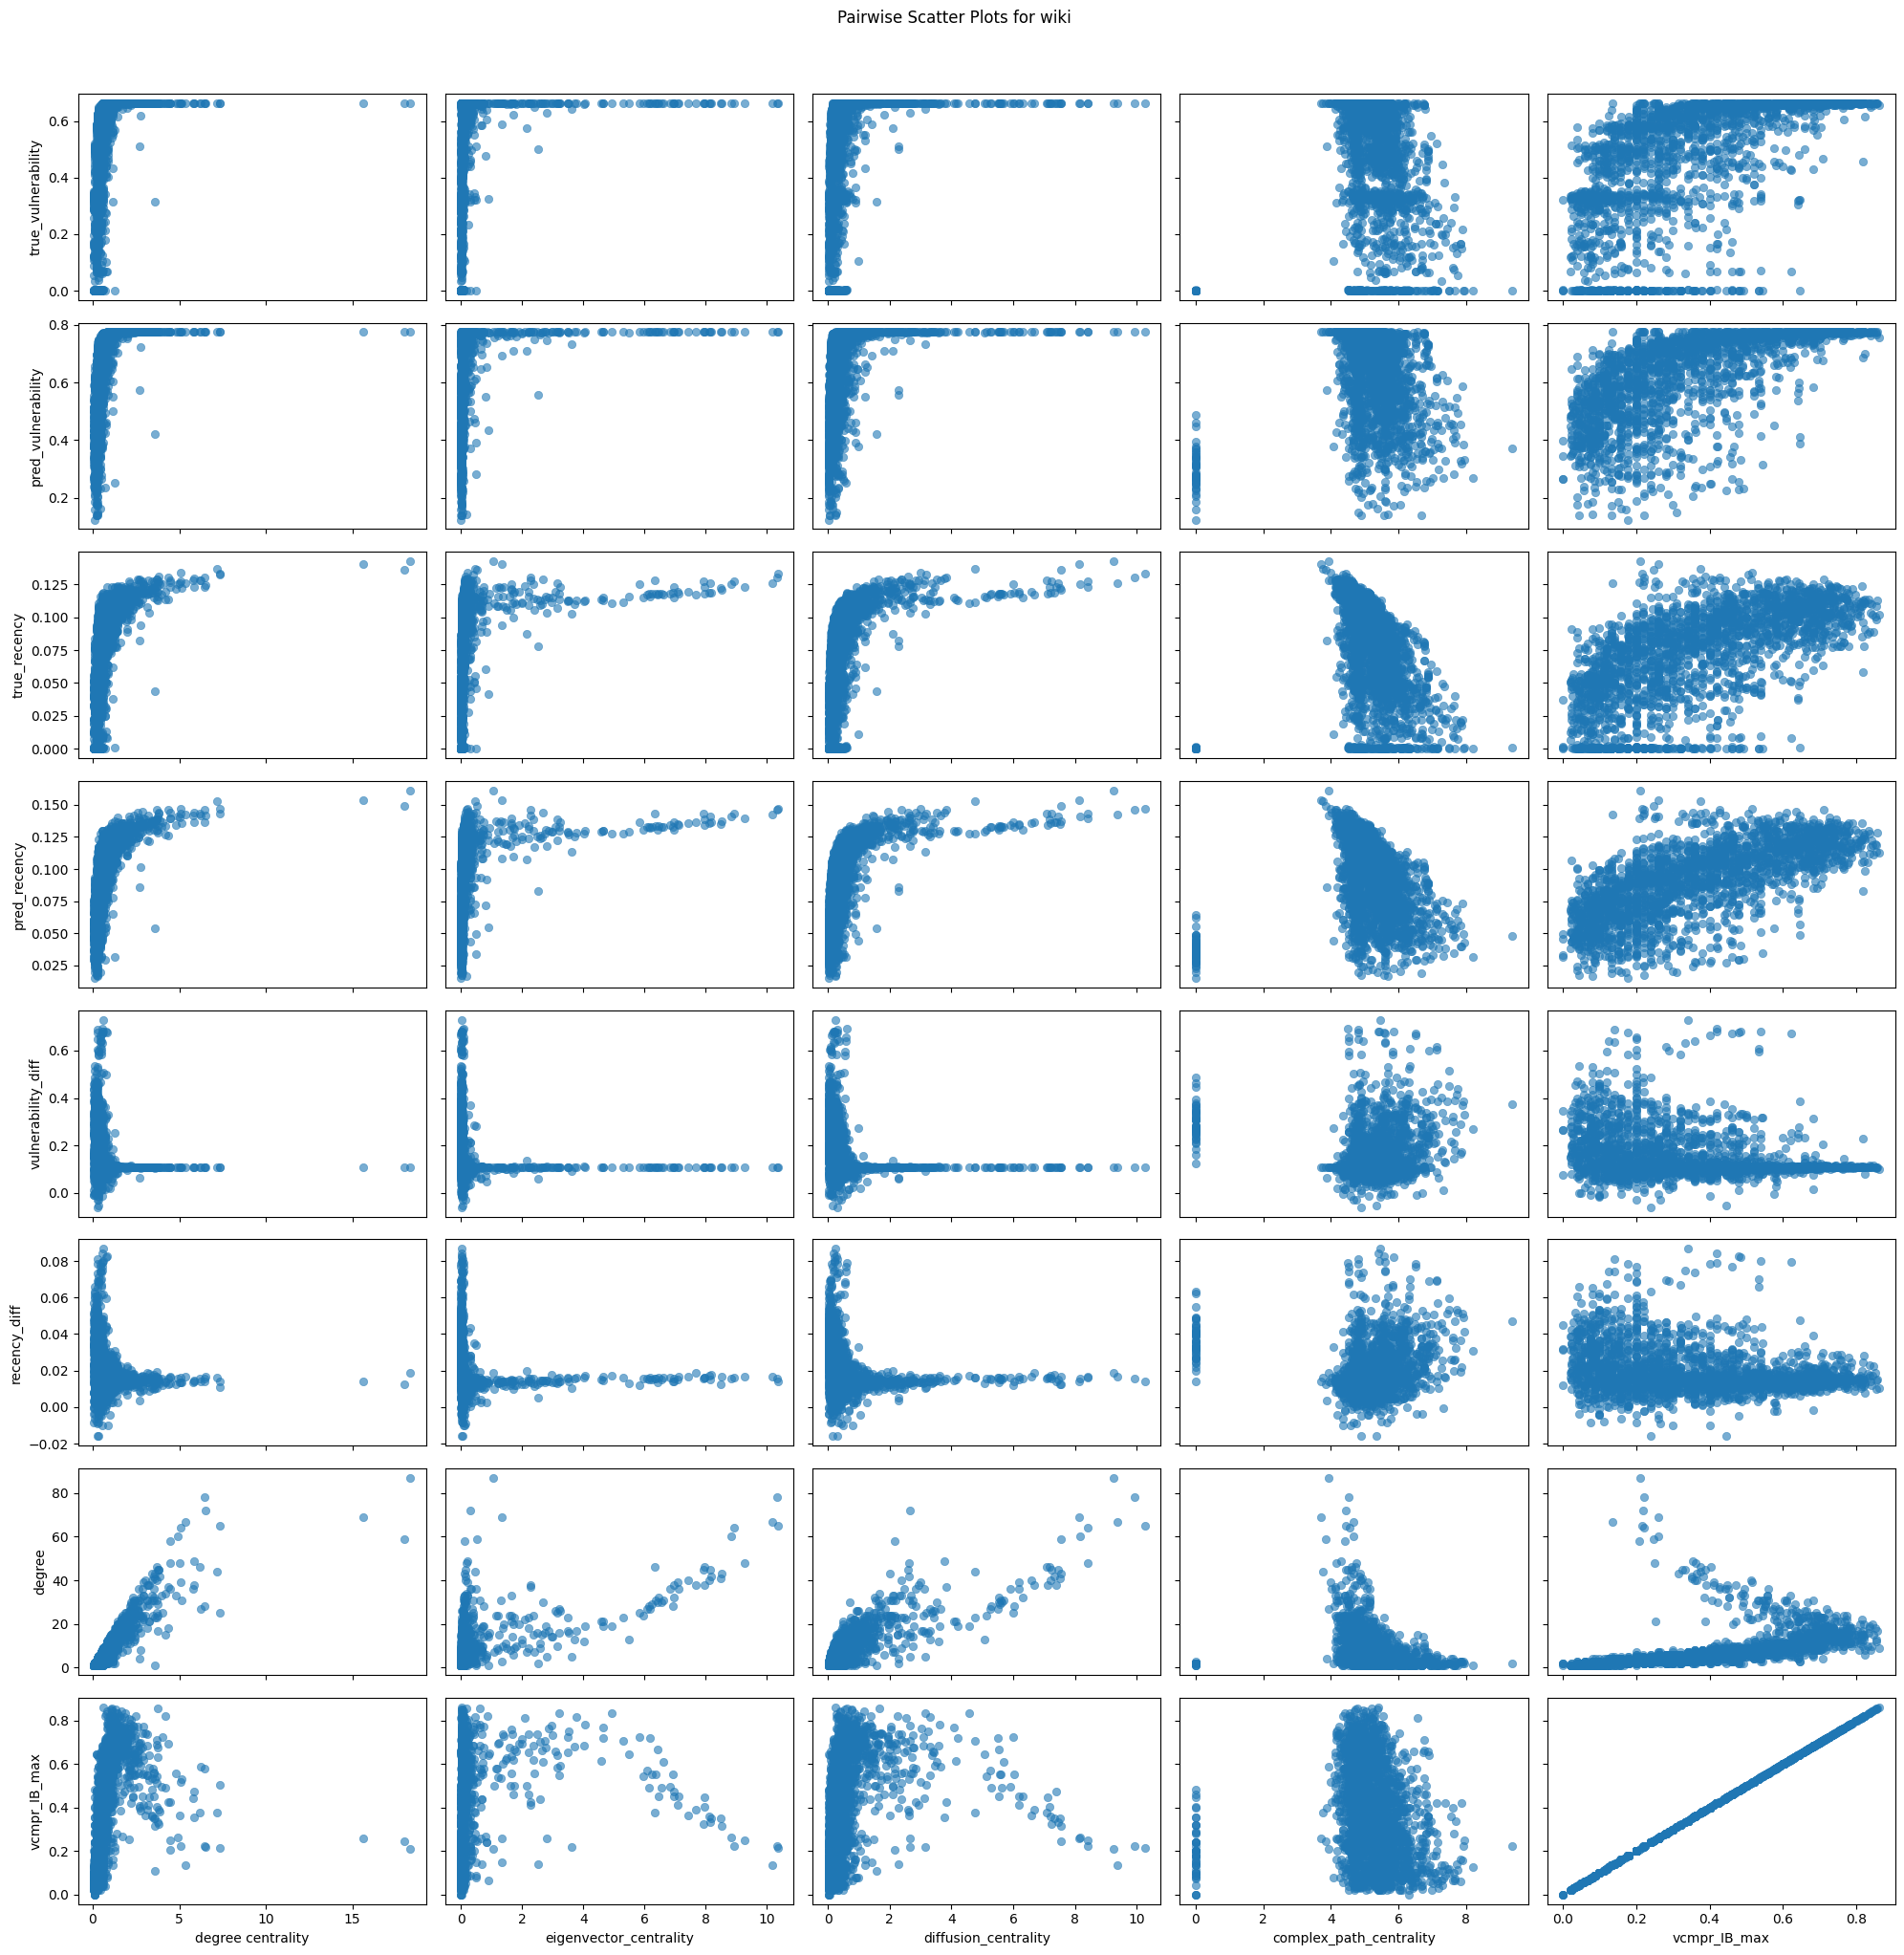

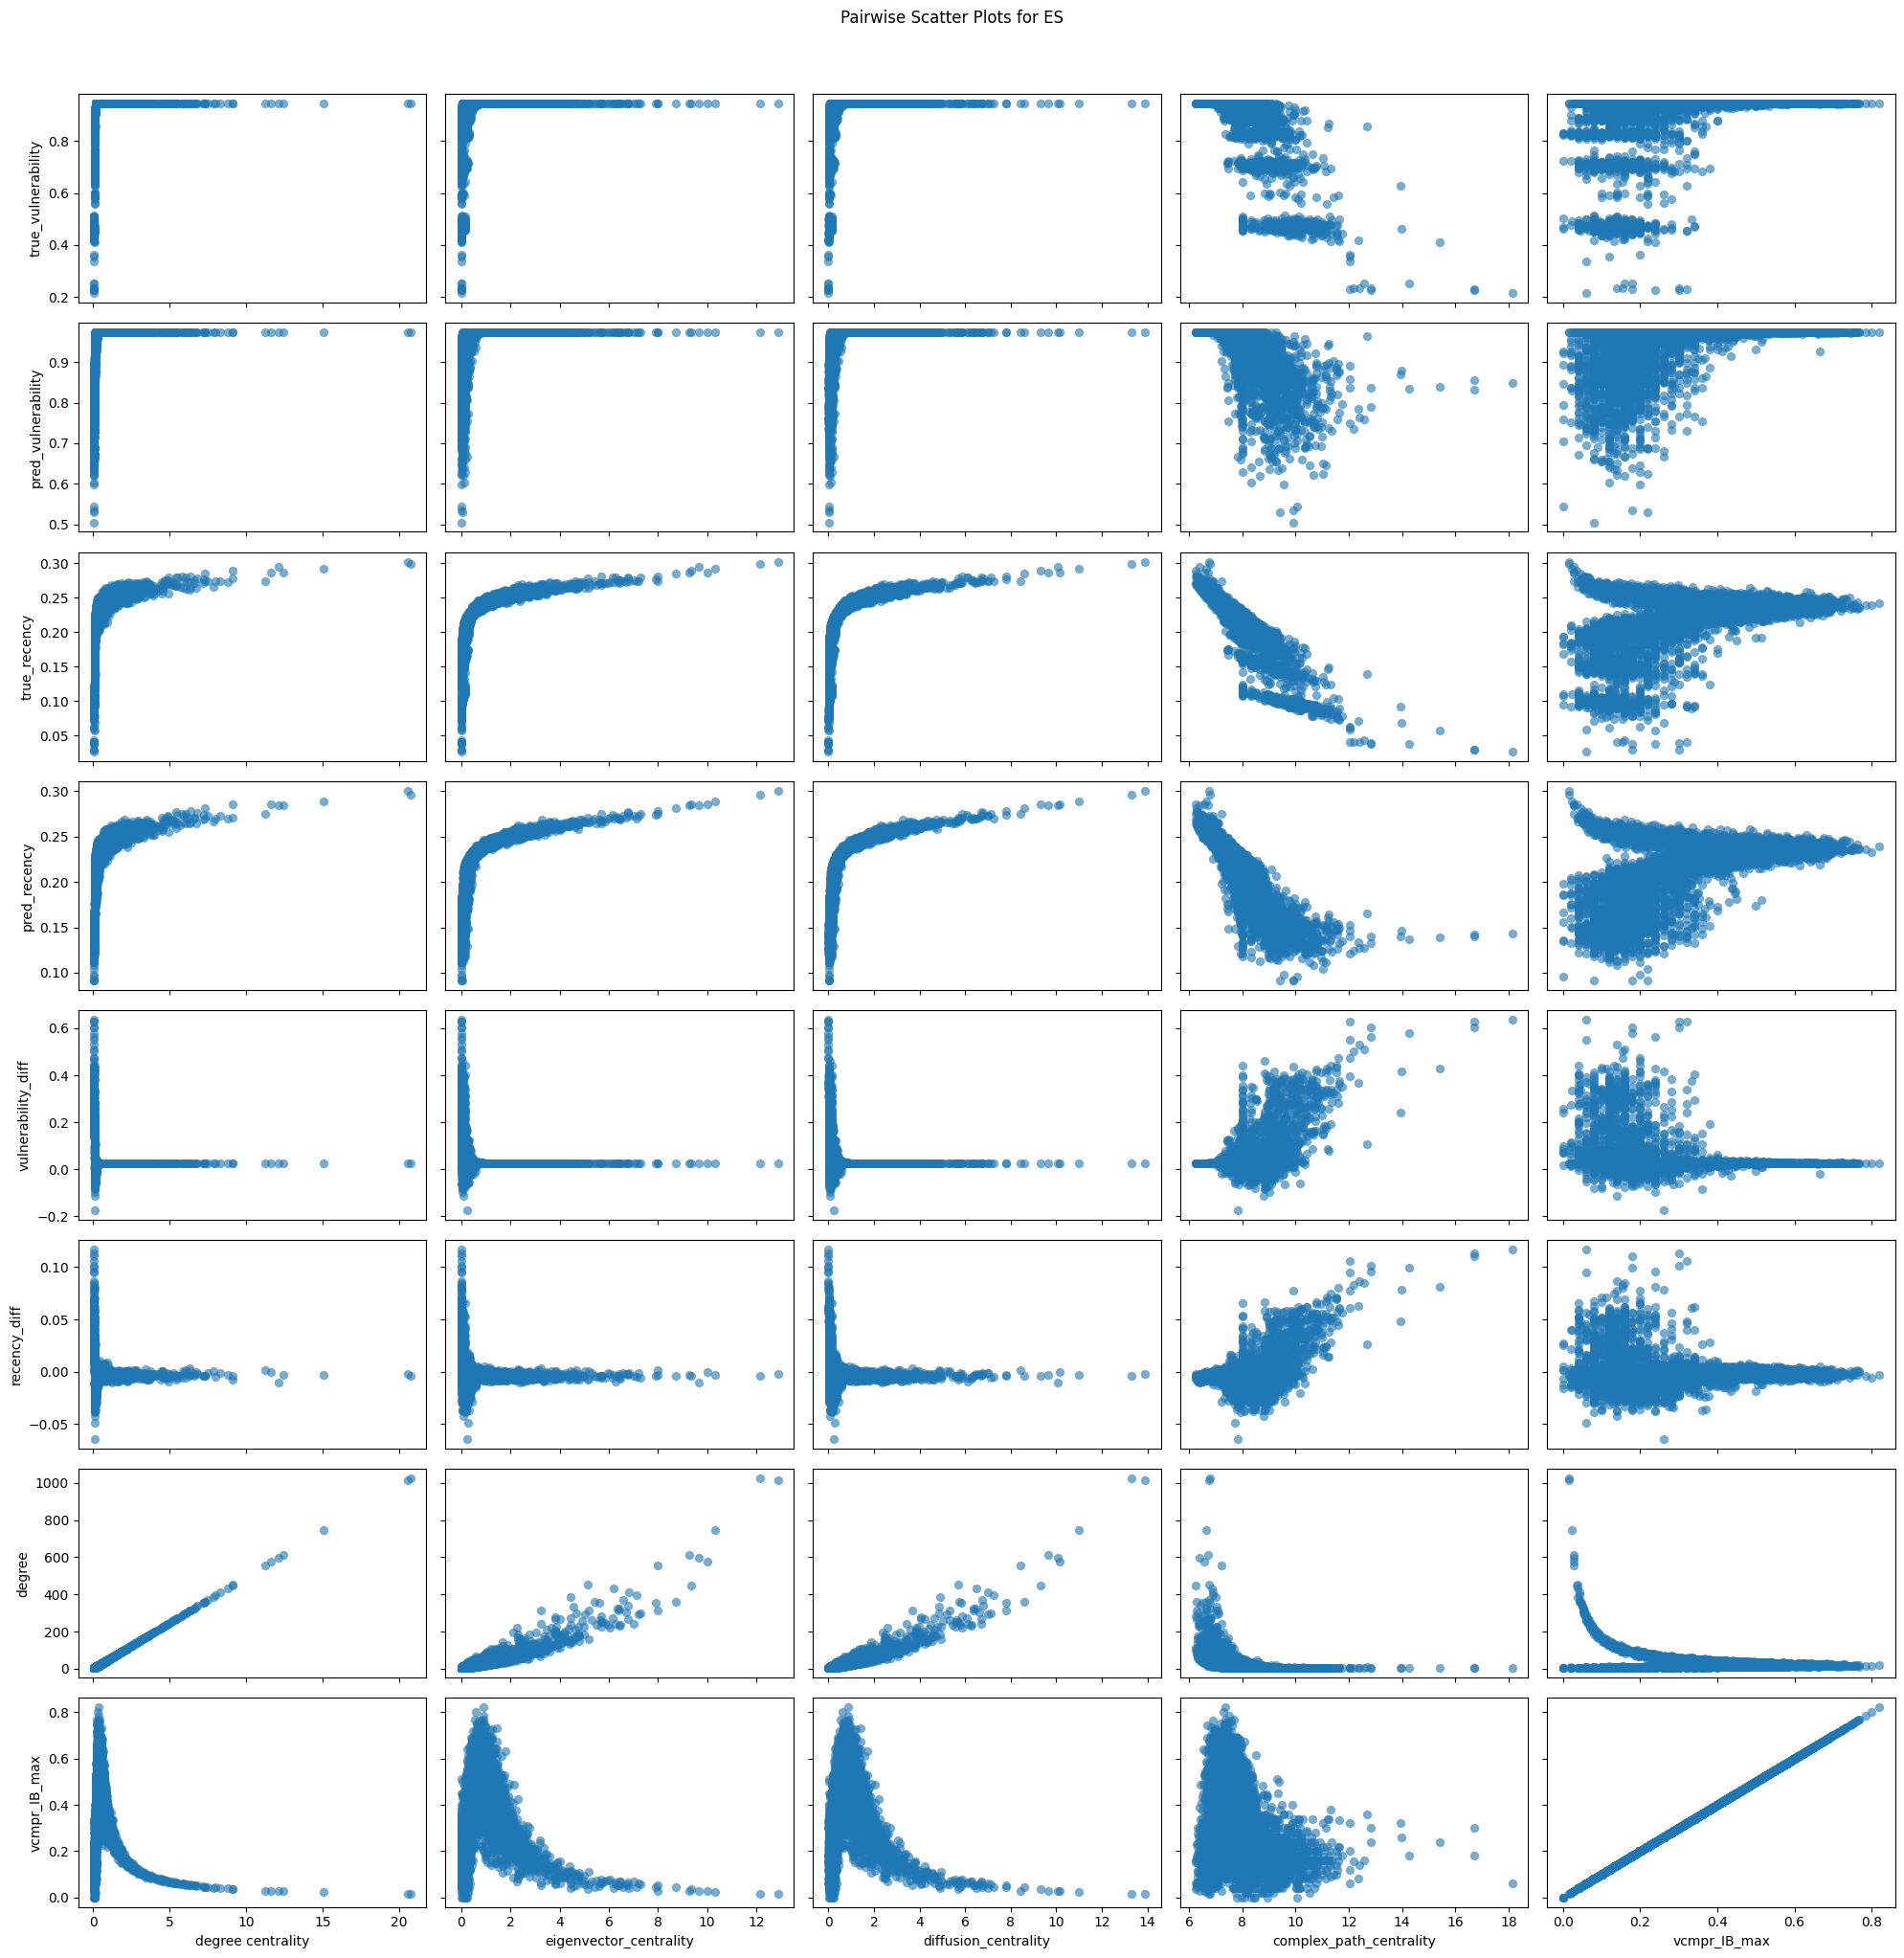

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define y-axis and x-axis features
y_features = ['true_vulnerability', 'pred_vulnerability', 'true_recency', 'pred_recency',
              'vulnerability_diff', 'recency_diff', 'degree', 'vcmpr_IB_max']
x_features = ['degree centrality', 'eigenvector_centrality',
              'diffusion_centrality', 'complex_path_centrality', 'vcmpr_IB_max']

# Set up the figure for the customized pairwise plots
for key in merged_dict.keys():
    fig, axes = plt.subplots(len(y_features), len(x_features), figsize=(20, 20), sharex='col', sharey='row')
    fig.suptitle(f"Pairwise Scatter Plots for {key}", y=1.02)
    
    # Plot each y_feature against each x_feature
    for i, y_feature in enumerate(y_features):
        for j, x_feature in enumerate(x_features):
            sns.scatterplot(data=merged_dict[key], x=x_feature, y=y_feature, ax=axes[i, j], alpha=0.6, edgecolor=None)
            axes[i, j].set_xlabel(x_feature if i == len(y_features) - 1 else "")  # Set x label only for bottom row
            axes[i, j].set_ylabel(y_feature if j == 0 else "")  # Set y label only for first column
    
    plt.tight_layout()
    plt.savefig(f"images/node_pairwise_gcn_s_{key}.png", bbox_inches="tight")
    plt.show()
